In [9]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

import cv2

# Creating keypoint dataset
import csv
import os

### **Mediapipe**

In [10]:
def mp_init_detector(model_path='mp-model/pose_landmarker.task'):
    # STEP 2: Create a PoseLandmarker object.
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=True)
    return vision.PoseLandmarker.create_from_options(options)

def mp_process_image(detector, mp_img):
    # Detect features in image
    detection_result = detector.detect(mp_img)

    # Associate enums with string values
    body_parts_dict = {
        'nose': mp.solutions.pose.PoseLandmark.NOSE,
        'left_eye_inner': mp.solutions.pose.PoseLandmark.LEFT_EYE_INNER,
        'left_eye': mp.solutions.pose.PoseLandmark.LEFT_EYE,
        'left_eye_outer': mp.solutions.pose.PoseLandmark.LEFT_EYE_OUTER,
        'right_eye_inner': mp.solutions.pose.PoseLandmark.RIGHT_EYE_INNER,
        'right_eye': mp.solutions.pose.PoseLandmark.RIGHT_EYE,
        'right_eye_outer': mp.solutions.pose.PoseLandmark.RIGHT_EYE_OUTER,
        'left_ear': mp.solutions.pose.PoseLandmark.LEFT_EAR,
        'right_ear': mp.solutions.pose.PoseLandmark.RIGHT_EAR,
        'mouth_left': mp.solutions.pose.PoseLandmark.MOUTH_LEFT,
        'mouth_right': mp.solutions.pose.PoseLandmark.MOUTH_RIGHT,
        'left_shoulder': mp.solutions.pose.PoseLandmark.LEFT_SHOULDER,
        'right_shoulder': mp.solutions.pose.PoseLandmark.RIGHT_SHOULDER,
        'left_elbow': mp.solutions.pose.PoseLandmark.LEFT_ELBOW,
        'right_elbow': mp.solutions.pose.PoseLandmark.RIGHT_ELBOW,
        'left_wrist': mp.solutions.pose.PoseLandmark.LEFT_WRIST,
        'right_wrist': mp.solutions.pose.PoseLandmark.RIGHT_WRIST,
        'left_pinky': mp.solutions.pose.PoseLandmark.LEFT_PINKY,
        'right_pinky': mp.solutions.pose.PoseLandmark.RIGHT_PINKY,
        'left_index': mp.solutions.pose.PoseLandmark.LEFT_INDEX,
        'right_index': mp.solutions.pose.PoseLandmark.RIGHT_INDEX,
        'left_thumb': mp.solutions.pose.PoseLandmark.LEFT_THUMB,
        'right_thumb': mp.solutions.pose.PoseLandmark.RIGHT_THUMB,
        'left_hip': mp.solutions.pose.PoseLandmark.LEFT_HIP,
        'right_hip': mp.solutions.pose.PoseLandmark.RIGHT_HIP,
        'left_knee': mp.solutions.pose.PoseLandmark.LEFT_KNEE,
        'right_knee': mp.solutions.pose.PoseLandmark.RIGHT_KNEE,
        'left_ankle': mp.solutions.pose.PoseLandmark.LEFT_ANKLE,
        'right_ankle': mp.solutions.pose.PoseLandmark.RIGHT_ANKLE,
        'left_heel': mp.solutions.pose.PoseLandmark.LEFT_HEEL,
        'right_heel': mp.solutions.pose.PoseLandmark.RIGHT_HEEL,
        'left_foot_index': mp.solutions.pose.PoseLandmark.LEFT_FOOT_INDEX,
        'right_foot_index': mp.solutions.pose.PoseLandmark.RIGHT_FOOT_INDEX
    }

    # Create a dictonary so we can index into body parts
    # EX Usage: body_parts['ankle_left]
    body_parts = {}
    if detection_result.pose_landmarks:
        for pose_landmarks in detection_result.pose_landmarks:
            for part_name, part_enum in body_parts_dict.items():
                body_parts[part_name] = pose_landmarks[part_enum]

    return detection_result, body_parts

### **Parsing dataset**

In [11]:
# Process video to extract keypoints
def process_video(detector, file_path):
    cap = cv2.VideoCapture(file_path)
    keypoints_list = []

    print(f"Processing video: {file_path}")
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

        # Process the original frame and extract keypoints
        success, keypoints = mp_process_image(detector, mp_img)

        # Store keypoints of the original frame in list
        if success:
            keypoints_list.append(keypoints)

        # Flip the frame horizontally
        flipped_frame = cv2.flip(frame, 1)
        rgb_flipped_frame = cv2.cvtColor(flipped_frame, cv2.COLOR_BGR2RGB)
        mp_flipped_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_flipped_frame)

        # Process the flipped frame and extract keypoints
        success, flipped_keypoints = mp_process_image(detector, mp_flipped_img)

        # Store keypoints of the flipped frame in list
        if success:
            keypoints_list.append(flipped_keypoints)

    cap.release()
    print(f"Finished processing video: {file_path}")
    return keypoints_list

# Write keypoints to CSV
def write_keypoints_to_csv(all_keypoints, output_csv):
    if not all_keypoints:
        return

    # Assuming all_keypoints is a list of tuples (keypoints, exercise_type)
    first_keypoints = all_keypoints[0][0][0] if all_keypoints[0][0] else None
    if not first_keypoints:
        return

    fieldnames = ['exercise_type'] + list(first_keypoints.keys())

    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for keypoints, exercise_type in all_keypoints:
            if not keypoints:
                continue
            for kp in keypoints:
                if not kp:
                    continue
                row = {'exercise_type': exercise_type}
                for part_name, landmark in kp.items():
                    row[part_name] = f"{landmark.x},{landmark.y},{landmark.z},{landmark.visibility}"
                writer.writerow(row)


def get_video_files_with_type(directory):
    exercise_type = os.path.basename(directory)
    video_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.mp4')]
    return exercise_type, video_files

def process_exercise_directories(input_directories, output_csv):
    mp_detector = mp_init_detector()
    all_keypoints = []

    for directory in input_directories:
        exercise_type, video_files = get_video_files_with_type(directory)
        print(f"Processing exercise type: {exercise_type}")
        for video in video_files:
            keypoints = process_video(mp_detector, video)
            all_keypoints.append((keypoints, exercise_type))

    print(f"Writing keypoints to CSV: {output_csv}")
    write_keypoints_to_csv(all_keypoints, output_csv)
    print(f"Finished writing keypoints to CSV: {output_csv}")

# Example usage:
input_directories = ['datasets/deadlift_data', 'datasets/pushup_data', 'datasets/squat_data']
output_csv = 'datasets/exercise_kp.csv'


process_exercise_directories(input_directories, output_csv)

I0000 00:00:1717729979.900542  885000 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1717729980.039238  917316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717729980.149396  917313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/homebrew/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Processing exercise type: deadlift_data
Processing video: datasets/deadlift_data/deadlift_17.mp4
Finished processing video: datasets/deadlift_data/deadlift_17.mp4
Processing video: datasets/deadlift_data/deadlift_16.mp4
Finished processing video: datasets/deadlift_data/deadlift_16.mp4
Processing video: datasets/deadlift_data/deadlift_14.mp4
Finished processing video: datasets/deadlift_data/deadlift_14.mp4
Processing video: datasets/deadlift_data/deadlift_15.mp4
Finished processing video: datasets/deadlift_data/deadlift_15.mp4
Processing video: datasets/deadlift_data/deadlift_11.mp4
Finished processing video: datasets/deadlift_data/deadlift_11.mp4
Processing video: datasets/deadlift_data/deadlift_10.mp4
Finished processing video: datasets/deadlift_data/deadlift_10.mp4
Processing video: datasets/deadlift_data/deadlift_13.mp4
Finished processing video: datasets/deadlift_data/deadlift_13.mp4
Processing video: datasets/deadlift_data/deadlift_9.mp4
Finished processing video: datasets/deadlif

### **Training**

In [12]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Seperate file cause errors were occuring
from posedata_set import CustomPoseDataset

In [13]:
def load_data(csv_file, batch_size=4):
    dataset = CustomPoseDataset(csv_file)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for keypoints, labels in test_loader:
            outputs = model(keypoints)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.4f}')

def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for keypoints, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * keypoints.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss * 100:.4f}, Accuracy: {epoch_acc * 100:.4f}')

    return model

In [14]:
# Define network
class PoseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PoseClassifier, self).__init__()
        # Each keypoint has 4 values (x, y, z, visibility) and there are 33 keypoints
        input_size = 33 * 4
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def define_network(device):
    net = PoseClassifier()
    net.to(device)
    return net


In [15]:
csv_file = 'datasets/exercise_kp.csv'

batch_size = 1000
num_epochs = 50
learning_rate = 0.001

train_loader, test_loader = load_data(csv_file, batch_size=batch_size)

num_classes = len(pd.read_csv(csv_file)['exercise_type'].unique())

model = PoseClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)
evaluate_model(model, test_loader)

# Save the model to the "model" folder
model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'pose_classifier.pth')
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Epoch 0/49, Loss: 88.0964, Accuracy: 57.4892
Epoch 1/49, Loss: 55.0593, Accuracy: 78.7484
Epoch 2/49, Loss: 38.8445, Accuracy: 86.1746
Epoch 3/49, Loss: 31.7654, Accuracy: 89.7827
Epoch 4/49, Loss: 26.5227, Accuracy: 91.8636
Epoch 5/49, Loss: 23.3673, Accuracy: 93.0510
Epoch 6/49, Loss: 21.1393, Accuracy: 93.9368
Epoch 7/49, Loss: 18.9330, Accuracy: 94.6737
Epoch 8/49, Loss: 17.4703, Accuracy: 94.9792
Epoch 9/49, Loss: 16.0419, Accuracy: 95.3457
Epoch 10/49, Loss: 15.1911, Accuracy: 95.6359
Epoch 11/49, Loss: 14.3250, Accuracy: 95.8192
Epoch 12/49, Loss: 13.7775, Accuracy: 96.0635
Epoch 13/49, Loss: 13.0897, Accuracy: 96.1284
Epoch 14/49, Loss: 12.2797, Accuracy: 96.3728
Epoch 15/49, Loss: 11.9562, Accuracy: 96.3537
Epoch 16/49, Loss: 11.4538, Accuracy: 96.5141
Epoch 17/49, Loss: 10.9042, Accuracy: 96.7088
Epoch 18/49, Loss: 10.1755, Accuracy: 96.9417
Epoch 19/49, Loss: 9.6255, Accuracy: 97.1937
Epoch 20/49, Loss: 9.2632, Accuracy: 97.1517
Epoch 21/49, Loss: 9.0942, Accuracy: 97.2891
E

### **Usage**

In [16]:
import cv2
import matplotlib.pyplot as plt

# Visual Helpers
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            solutions.pose.POSE_CONNECTIONS,
            solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

def cv2_imshow(image):
    """
    Display an image using matplotlib in Jupyter Notebook.

    Args:
        image: The image to display. Should be in BGR format (OpenCV default).
    """
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()

def mp_debug_show_image(detector, img_path):
    image = mp.Image.create_from_file(img_path)

    if image is None:
        raise ValueError(f"Image at path {img_path} could not be loaded.")

    detection_result, _ = mp_process_image(detector, image)

    image_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # STEP 5: Process the detection result. In this case, visualize it.
    annotated_image = draw_landmarks_on_image(
        image_rgb,
        detection_result
    )

    # Display the annotated image, otherwise return it.
    cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


### **Model Usage**

In [17]:
def preprocess_keypoints(keypoints):
    # Extract x, y, z, and visibility from each keypoint
    keypoints_array = np.array([[kp.x, kp.y, kp.z, kp.visibility] for kp in keypoints.values()]).astype(np.float32)
    keypoints_flat = keypoints_array.flatten()
    keypoints_tensor = torch.tensor(keypoints_flat).unsqueeze(0)  # Add batch dimension
    return keypoints_tensor

In [18]:
csv_file = 'datasets/exercise_kp.csv'
model_path = 'model/pose_classifier.pth'

num_classes = len(pd.read_csv(csv_file)['exercise_type'].unique())
model = PoseClassifier(num_classes=num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

PoseClassifier(
  (fc1): Linear(in_features=132, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

I0000 00:00:1717734402.220700  885000 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1717734402.339340  948086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717734402.397695  948086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/homebrew/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


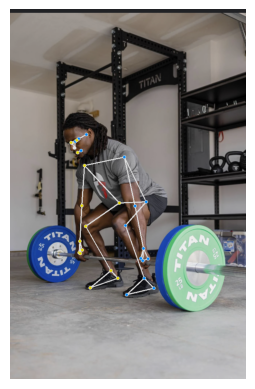

Predicted class: deadlift


In [19]:
# Static Usage
src_img = "sample-frames/deadlift.png"
mp_detector = mp_init_detector()
mp_image = mp.Image.create_from_file(src_img)
detection_results, key_points = mp_process_image(
    mp_detector,
    mp_image
)

# Preprocess the keypoints
input_tensor = preprocess_keypoints(key_points)

# Classify the keypoints
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

predicted_class = predicted.item()

# Output
mp_debug_show_image(mp_detector, src_img)

# Load and clean class labels
class_labels = pd.read_csv('datasets/exercise_kp.csv')['exercise_type'].unique()
class_labels = [label.replace('_data', '') for label in class_labels]
class_index_to_label = {index: label for index, label in enumerate(class_labels)}

predicted_class_index = predicted.item()
predicted_class_label = class_index_to_label[predicted_class_index]
print(f'Predicted class: {predicted_class_label}')


In [20]:
# Webcam (for fun)
# Load the model
num_classes = len(pd.read_csv('datasets/exercise_kp.csv')['exercise_type'].unique())
model = PoseClassifier(num_classes=num_classes)
model_path = 'model/pose_classifier.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Load and clean class labels
class_labels = pd.read_csv('datasets/exercise_kp.csv')['exercise_type'].unique()
class_labels = [label.replace('_data', '') for label in class_labels]
class_index_to_label = {index: label for index, label in enumerate(class_labels)}

# Initialize MediaPipe detector
mp_detector = mp_init_detector()

# Initialize webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to RGB as MediaPipe expects RGB images
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    # Process the frame
    detection_results, key_points = mp_process_image(mp_detector, mp_img)

    if key_points:
        # Preprocess the keypoints
        input_tensor = preprocess_keypoints(key_points)

        # Classify the keypoints
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)

        predicted_class_index = predicted.item()
        predicted_class_label = class_index_to_label[predicted_class_index]

        # Display the predicted class label on the frame
        cv2.putText(frame, f'Predicted class: {predicted_class_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the frame with landmarks
    # mp_drawing = mp.solutions.drawing_utils
    # mp_drawing.draw_landmarks(frame, detection_results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)
    cv2.imshow('MediaPipe Pose', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1717734405.186713  885000 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1717734405.265096  948137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717734405.297941  948137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/homebrew/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


: 